In [1]:
import functools
import time
from tqdm.notebook import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms

import matplotlib.pyplot as plt

In [2]:
def timer(func):
    @functools.wrap(func)
    def wrapper(*args, **kwargs):
        stime = time.perf_counter()
        res = func(*args, **kwargs)
        elapsed = time.perf_counter() - stime
        print(f"{func.__name__} in {elapsed:.4f} secs")
        return res
    return wrapper

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# data
data_mean = (0.491, 0.482, 0.447)
data_std = (0.247, 0.243, 0.262)
train_tx = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])
test_tx = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

batch_size = 32
num_classes = 10
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, download=True, transform=train_tx),
    batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, download=True, transform=test_tx),
    batch_size=batch_size, shuffle=False, num_workers=4
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# model
# model = models.resnet18(pretrained=True) # 224x224 input, 1000 classes, not suitable for CIFAR10
# model.fc = nn.Linear(512, num_classes) # output (ImageNet: 1000 classes -> CIFAR10: 10 classes)
# model.to(device)

In [6]:
# model (resnet18, 32x32, 10classes)
# Mixing two implementations from
# - source from torchvision: https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
# - source from keras: https://keras.io/zh/examples/cifar10_resnet/
# bias is set to False since BN will handle it
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(BasicBlock, self).__init__()        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(2 if downsample else 1), 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=True) if downsample else nn.Identity()
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.res(x)
        out = self.relu2(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, blocks, num_classes=10, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.base_channels = 64
        self.conv1 = nn.Conv2d(3, self.base_channels, kernel_size=3, stride=1, padding=1, bias=False) # 32x32
        self.bn1 = nn.BatchNorm2d(self.base_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_block(self.base_channels, 64, blocks[0], downsample=False) # 32x32
        self.layer2 = self._make_block(64, 128, blocks[1], downsample=True) # 16x16
        self.layer3 = self._make_block(128, 256, blocks[2], downsample=True) # 8x8        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 1x1
        self.fc = nn.Linear(256, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
                    
    def _make_block(self, in_channels, out_channels, how_many, downsample):
        layers = list()
        layers.append(BasicBlock(in_channels, out_channels, downsample=downsample))
        for _ in range(1, how_many):
            layers.append(BasicBlock(out_channels, out_channels, downsample=False))
        return nn.Sequential(*layers)
    
    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)        
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)        
        return x
    
    def forward(self, x):
        return self._forward(x)     
            
def resnet18(**kwargs):
    return ResNet([3, 3, 3], **kwargs)

model = resnet18()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res): Identity()
      (relu2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, 

In [7]:
# train/eval (per epoch)
def train(model, device, data_loader, optimizer):
    model.train()
    train_loss = 0    
    for batch_idx, (data, target) in tqdm(enumerate(data_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = nn.functional.cross_entropy(pred, target)        
        loss.backward()
        optimizer.step()        
        train_loss += loss.item()
    train_loss /= len(data_loader.dataset)
    return train_loss

def test(model, device, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            pred = model(data)
            test_loss += nn.functional.cross_entropy(pred, target).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(data_loader.dataset)
    return test_loss, correct   

In [8]:
# optimizer and lr scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)


1/80: train_loss=0.042644, test_loss=0.034781,           test_acc=0.6207



2/80: train_loss=0.028932, test_loss=0.039625,           test_acc=0.6115



3/80: train_loss=0.023196, test_loss=0.025575,           test_acc=0.7273



4/80: train_loss=0.020040, test_loss=0.021841,           test_acc=0.7714



5/80: train_loss=0.018048, test_loss=0.018488,           test_acc=0.8002



6/80: train_loss=0.016559, test_loss=0.016819,           test_acc=0.8158



7/80: train_loss=0.015231, test_loss=0.015470,           test_acc=0.8377



8/80: train_loss=0.014061, test_loss=0.014743,           test_acc=0.8370



9/80: train_loss=0.013226, test_loss=0.013734,           test_acc=0.8566



10/80: train_loss=0.012534, test_loss=0.014882,           test_acc=0.8456



11/80: train_loss=0.011976, test_loss=0.013973,           test_acc=0.8505



12/80: train_loss=0.011321, test_loss=0.012484,           test_acc=0.8698



13/80: train_loss=0.011064, test_loss=0.011426,           test_acc=0.8762



14/80: train_loss=0.010551, test_loss=0.011392,           test_acc=0.8736



15/80: train_loss=0.010413, test_loss=0.013104,           test_acc=0.8633



16/80: train_loss=0.010027, test_loss=0.012387,           test_acc=0.8728



17/80: train_loss=0.009832, test_loss=0.012200,           test_acc=0.8696



18/80: train_loss=0.009572, test_loss=0.010522,           test_acc=0.8883



19/80: train_loss=0.009170, test_loss=0.011891,           test_acc=0.8778



20/80: train_loss=0.009204, test_loss=0.011348,           test_acc=0.8829



21/80: train_loss=0.008935, test_loss=0.012134,           test_acc=0.8767



22/80: train_loss=0.008710, test_loss=0.011529,           test_acc=0.8789



23/80: train_loss=0.008680, test_loss=0.011095,           test_acc=0.8833



24/80: train_loss=0.008586, test_loss=0.011366,           test_acc=0.8822



25/80: train_loss=0.008391, test_loss=0.011066,           test_acc=0.8839



26/80: train_loss=0.008219, test_loss=0.011400,           test_acc=0.8821



27/80: train_loss=0.008130, test_loss=0.009813,           test_acc=0.8985



28/80: train_loss=0.008014, test_loss=0.010353,           test_acc=0.8901



29/80: train_loss=0.008064, test_loss=0.011495,           test_acc=0.8805



30/80: train_loss=0.007774, test_loss=0.010154,           test_acc=0.8935



31/80: train_loss=0.007814, test_loss=0.010314,           test_acc=0.8923



32/80: train_loss=0.007652, test_loss=0.010736,           test_acc=0.8905



33/80: train_loss=0.007561, test_loss=0.009136,           test_acc=0.9035



34/80: train_loss=0.007610, test_loss=0.011950,           test_acc=0.8803



35/80: train_loss=0.007520, test_loss=0.011085,           test_acc=0.8868



36/80: train_loss=0.007434, test_loss=0.011043,           test_acc=0.8849



37/80: train_loss=0.007315, test_loss=0.011378,           test_acc=0.8834



38/80: train_loss=0.007350, test_loss=0.010608,           test_acc=0.8891



39/80: train_loss=0.007207, test_loss=0.009851,           test_acc=0.8987



40/80: train_loss=0.007156, test_loss=0.009894,           test_acc=0.9000



41/80: train_loss=0.004590, test_loss=0.007335,           test_acc=0.9237



42/80: train_loss=0.003721, test_loss=0.007293,           test_acc=0.9250



43/80: train_loss=0.003401, test_loss=0.007221,           test_acc=0.9271



44/80: train_loss=0.003080, test_loss=0.007410,           test_acc=0.9268



45/80: train_loss=0.002901, test_loss=0.007331,           test_acc=0.9282



46/80: train_loss=0.002704, test_loss=0.007490,           test_acc=0.9278



47/80: train_loss=0.002489, test_loss=0.007571,           test_acc=0.9285



48/80: train_loss=0.002392, test_loss=0.007765,           test_acc=0.9261



49/80: train_loss=0.002209, test_loss=0.007711,           test_acc=0.9289



50/80: train_loss=0.002191, test_loss=0.007686,           test_acc=0.9276



51/80: train_loss=0.002051, test_loss=0.007828,           test_acc=0.9269



52/80: train_loss=0.001998, test_loss=0.007813,           test_acc=0.9289



53/80: train_loss=0.001917, test_loss=0.007865,           test_acc=0.9296



54/80: train_loss=0.001729, test_loss=0.008438,           test_acc=0.9267



55/80: train_loss=0.001795, test_loss=0.008269,           test_acc=0.9277



56/80: train_loss=0.001561, test_loss=0.008408,           test_acc=0.9280



57/80: train_loss=0.001593, test_loss=0.008517,           test_acc=0.9270



58/80: train_loss=0.001551, test_loss=0.008406,           test_acc=0.9276



59/80: train_loss=0.001445, test_loss=0.008364,           test_acc=0.9279



60/80: train_loss=0.001501, test_loss=0.008730,           test_acc=0.9277



61/80: train_loss=0.001347, test_loss=0.008932,           test_acc=0.9264



62/80: train_loss=0.001442, test_loss=0.008840,           test_acc=0.9283



63/80: train_loss=0.001299, test_loss=0.008956,           test_acc=0.9268



64/80: train_loss=0.001320, test_loss=0.009070,           test_acc=0.9279



65/80: train_loss=0.001346, test_loss=0.009002,           test_acc=0.9264



66/80: train_loss=0.001228, test_loss=0.009364,           test_acc=0.9230



67/80: train_loss=0.001215, test_loss=0.009080,           test_acc=0.9276



68/80: train_loss=0.001154, test_loss=0.009227,           test_acc=0.9278



69/80: train_loss=0.001177, test_loss=0.009091,           test_acc=0.9259



70/80: train_loss=0.001124, test_loss=0.009279,           test_acc=0.9280



71/80: train_loss=0.001105, test_loss=0.009197,           test_acc=0.9271



72/80: train_loss=0.001081, test_loss=0.009392,           test_acc=0.9282



73/80: train_loss=0.001080, test_loss=0.009224,           test_acc=0.9287



74/80: train_loss=0.000985, test_loss=0.009805,           test_acc=0.9293



75/80: train_loss=0.001049, test_loss=0.009849,           test_acc=0.9264



76/80: train_loss=0.000961, test_loss=0.009712,           test_acc=0.9276



77/80: train_loss=0.001055, test_loss=0.010055,           test_acc=0.9251



78/80: train_loss=0.000969, test_loss=0.009821,           test_acc=0.9266



79/80: train_loss=0.000999, test_loss=0.009753,           test_acc=0.9270



80/80: train_loss=0.000986, test_loss=0.009297,           test_acc=0.9307


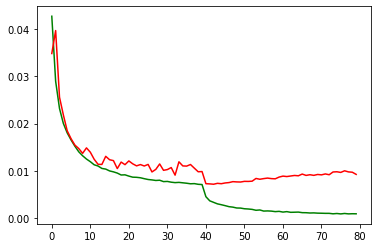

In [9]:
# main
epochs = 80
train_log = list()
test_log = list()
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer)
    test_loss, correct = test(model, device, test_loader)
    lr_scheduler.step()
    
    print(f"{epoch}/{epochs}: train_loss={train_loss:.6f}, test_loss={test_loss:.6f}, \
          test_acc={correct / len(test_loader.dataset):.4f}")
    train_log.append(train_loss)
    test_log.append(test_loss) 
    
plt.plot(train_log, color='green')
plt.plot(test_log, color='red')
plt.show()
    
# if save_model:
#     torch.save(model.state_dict(), 'cifar10_resnet18.pt')